In [1]:
from matplotlib.mlab import griddata
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import cm, rcParams

title_sz = 27
axis_sz = 22
tick_sz = 21

import numpy as np
import pylab as pl
from scipy import stats
%matplotlib inline

In [2]:
from chem_ocean.ocean_data import dataFetcher, water_column
from chem_ocean.ocean_plt import rawPlotter
# from chem_ocean.ocean_plt_util import save_name
# import chem_ocean.ocean_analysis as oc_an

['section']
12.0
0 4


(5500, 0)

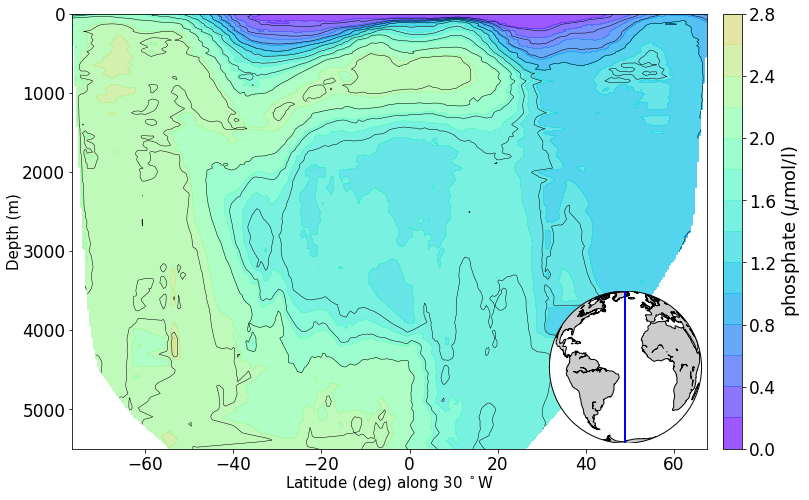

In [3]:
lineLon = -30
minLat, maxLat = -80, 80
tracer = 'phosphate'

newPlot = rawPlotter(['section'], [tracer])
fig, ax_out = newPlot.make()

dataset = dataFetcher()
dataset.get_section('NS_section', lineLon, [minLat, maxLat], [tracer])
maxdepth_1 = max(dataset._d)

fig, ax_out[0] = newPlot.add_section(fig, ax_out[0], dataset, tracer, colorbar = 'y', share_limits =True)

ax_out[0].set_ylim([5500, 0])

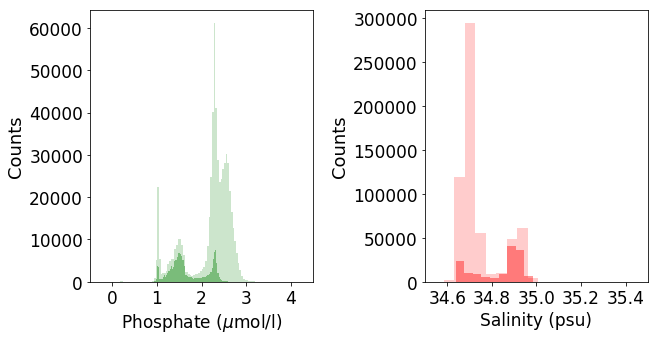

In [4]:
tracers = {'phosphate': ['Phosphate ($\mu$mol/l)', [-.5, 4.5], 'g'], 
           'salinity': ['Salinity (psu)', [34.5, 35.5], 'r'] }

_x_var = 'longitude'
_y_var = 'latitude'

fig = plt.figure(figsize = (10,5))
gs = gridspec.GridSpec(1,2, width_ratios=[1,1], wspace=0.5, hspace = 0.4) 
ax_out = []

for ik, tracer in enumerate(tracers):
    ax_out.append(fig.add_subplot(gs[ik]))
    
    _in_var_names = [tracer]
    sum_names = ['station', 'longitude', 'latitude', 'depth'] + _in_var_names
    cols = ', '.join(sum_names)

    # Atlantic Basin below 2500m
    query = 'SELECT '+ cols+' FROM woa13 WHERE depth>2500 and longitude >-70 and longitude < 15'
    dataset = dataFetcher()
    dataset.return_from_psql(query, sum_names, _in_var_names, _x_var, _y_var)
    n, bins, patches = ax_out[ik].hist(dataset._feat_data, 100, color = tracers[tracer][2], alpha = .4)

    # Global Ocean below 2500m
    query = 'SELECT '+ cols+' FROM woa13 WHERE depth>2500'
    dataset2 = dataFetcher()
    dataset2.return_from_psql(query, sum_names, _in_var_names, _x_var, _y_var)
    n, bins, patches = ax_out[ik].hist(dataset2._feat_data, 100, color =  tracers[tracer][2], alpha = .2)

    ax_out[ik].set_xlim(tracers[tracer][1])

    ax_out[ik].set_ylabel('Counts', fontsize=axis_sz-4)
    ax_out[ik].set_xlabel(tracers[tracer][0], fontsize=axis_sz-5)
                       
    xtickNames = ax_out[ik].get_xticklabels()
    ytickNames = ax_out[ik].get_yticklabels()
    
    for names in [ytickNames, xtickNames]:
        plt.setp(names, rotation=0, fontsize=tick_sz-4)


phosphate
	 3000 -167.268949049 2.66283833081e-219
	 3500 -75.3757678996 6.82738100016e-73
	 4000 -22.2649946327 1.8625828055e-15
	 4500 nan nan
	 5000 nan nan
	 5500 nan nan
salinity
	 3000 168.975628582 1.7033218313e-176
	 3500 246.211427833 2.7741844131e-125
	 4000 299.712757958 2.31425147662e-42
	 4500 nan nan
	 5000 nan nan
	 5500 nan nan
temperature
	 3000 97.6257581701 2.16034546348e-184
	 3500 189.868326396 8.74118490401e-240
	 4000 66.3901003223 1.49892883161e-25
	 4500 nan nan
	 5000 nan nan
	 5500 nan nan


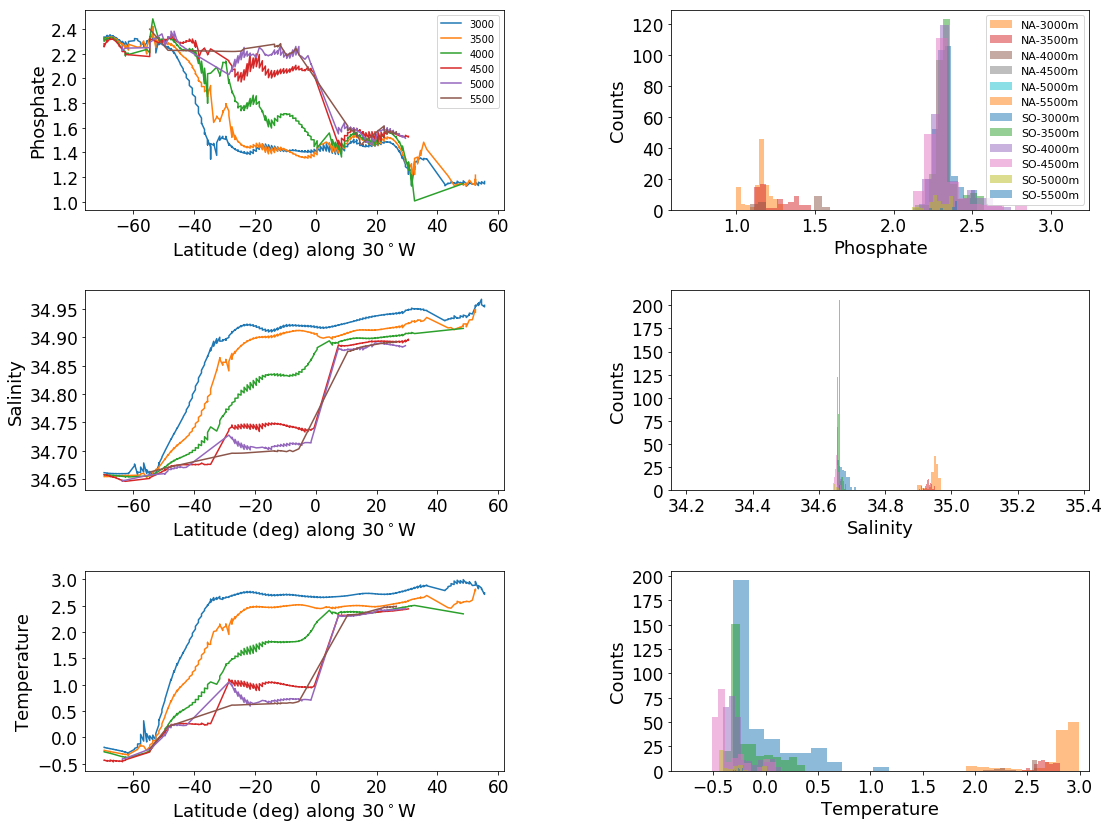

In [5]:
# for all tracers
tracers = ['phosphate', 'salinity', 'temperature']
lineLon = -30
minLat, maxLat = -70, 80

fig = plt.figure(figsize=(18, 14))
gs = gridspec.GridSpec(len(tracers),2, width_ratios=[1,1], wspace=0.4, hspace = 0.4) 
ax_out = []
for ik in range(len(tracers)*2):
    ax_out.append(fig.add_subplot(gs[ik]))

for ik, tracer in enumerate(tracers):
    print(tracer)
    dataset_NA = dataFetcher()
    dataset_NA.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude <70 and latitude > 50 and longitude < -20 and longitude >-40 order by depth'.format(tracer),['latitude', 'longitude', 'depth', tracer], [tracer], 'longitude', 'latitude')

    NAtl_60 = water_column(dataset_NA, 'column')

    dataset_SA = dataFetcher()
    dataset_SA.return_from_psql('SELECT latitude, longitude, depth, {} from woa13 WHERE latitude <-50 and latitude > -70 and longitude < -20 and longitude >-40 order by depth'.format(tracer),['latitude', 'longitude', 'depth', tracer], [tracer], 'longitude', 'latitude')

    SAtl_60 = water_column(dataset_SA, 'column')
        
    section_dataset = dataFetcher()
    section_dataset.get_section('NS_section', lineLon, [minLat, maxLat], [tracer])

    depths = [3000, 3500, 4000, 4500, 5000, 5500]
    for depth in depths:
        data_NA = dataset_NA._feat_data[dataset_NA._d==depth]
        data_SA = dataset_SA._feat_data[dataset_SA._d==depth]
        ax_out[2*ik+1].hist(data_SA, label = 'SO-'+ str(depth)+'m', alpha=.5)
        ax_out[2*ik+1].hist(data_NA, label = 'NA-'+ str(depth)+'m', alpha = .5)
        ax_out[2*ik+1].set_ylabel('Counts', fontsize=axis_sz-4)
        ax_out[2*ik+1].set_xlabel(tracer.title(), fontsize=axis_sz-4)
        
        t2, p2 = stats.ttest_ind(data_NA,data_SA, equal_var=False)
        print('\t',depth, t2, p2)
        
        ax_out[2*ik].plot(section_dataset._x[section_dataset._d==depth], section_dataset._feat_data[section_dataset._d==depth], label=str(depth))
        
        ax_out[2*ik].set_ylabel(tracer.title(), fontsize=axis_sz-4)
        ax_out[2*ik].set_xlabel('Latitude (deg) along {}$^\circ$W'.format(-lineLon), fontsize=axis_sz-4)
        try:
            ax_out[2*ik+1].set_xlim([min([min(data_NA), min(data_SA)])-.5, max([max(data_NA), max(data_SA)])+.5])
        except:
            continue
    if ik == 0:
        handles, labels = ax_out[2*ik+1].get_legend_handles_labels()
        
        # sort both labels and handles by labels
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        ax_out[2*ik+1].legend(handles, labels)
        ax_out[2*ik].legend(prop={'size': 10})
        

    # set tick parameters
    for ij in [2*ik, 2*ik+1]:
        xtickNames = ax_out[ij].get_xticklabels()
        ytickNames = ax_out[ij].get_yticklabels()

        for names in [ytickNames, xtickNames]:
            plt.setp(names, rotation=0, fontsize=tick_sz-4)


![TwoEndmemberMixingCartoon](https://github.com/jordanplanders/Thinkful/blob/master/Capstone%20Project/jlanders_capstone_img/two_endmember_cartoon.png?raw=true)

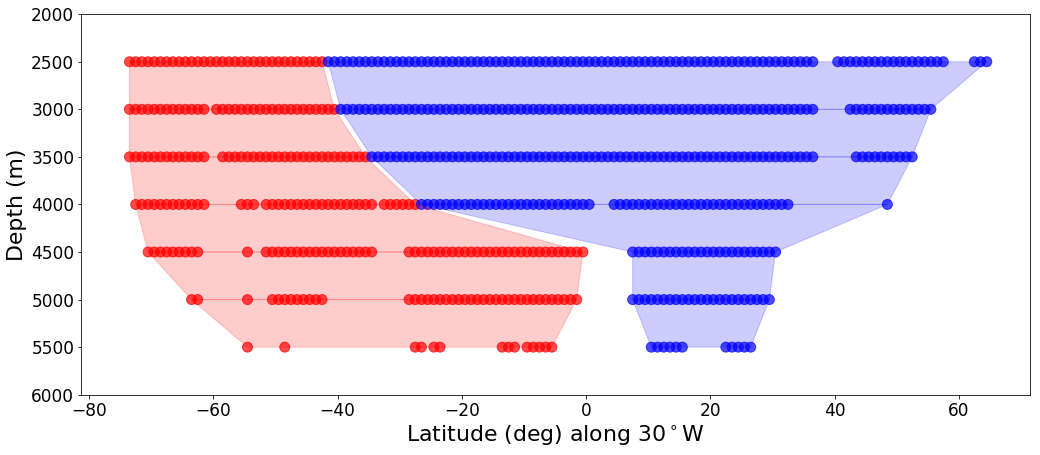

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(17, 7), facecolor='w')

tracer = 'salinity'
dataset = dataFetcher()
dataset.get_section('NS_section', lineLon, [minLat, maxLat], [tracer])

depths = [2500, 3000, 3500, 4000, 4500, 5000, 5500]
r = []
b = []
d_traj = {}

for ij, dpth in enumerate(depths):
    Atl = water_column(dataset, 'traj', depth= dpth)
    Atl.get_mixing_labels('two_endmember')
    d_traj[dpth] = Atl
    ax.scatter(Atl._ax_avgd, [dpth for ik in range(len(Atl._feat_data_avgd))], c = Atl.mixing_labels, alpha = .7, s=100)
    ax.set_ylim([6000,2000])
    
    # create lists of latitudes where there are red points and blue points
    x_int_r = []
    x_int_b = []
    for ik in range(len(Atl._feat_data_avgd)):
        if Atl.mixing_labels[ik] == 'r':
            x_int_r.append(Atl._ax_avgd[ik])
        else:
            x_int_b.append(Atl._ax_avgd[ik])
    
    # create lists of bounding points for each depth
    r.append([dpth, x_int_r[0], x_int_r[-1]])
    b.append([dpth, x_int_b[0], x_int_b[-1]])

### fill code
r_pairs = [[r[n-1], r[n]] for n in range(1,len(r))]
b_pairs = [[b[n-1], b[n]] for n in range(1,len(b))]

pair_sets = {'r':[r_pairs, []], 'b':[b_pairs,[]]}

for color in pair_sets.keys():
    for pair in pair_sets[color][0]:
        ul = [pair[0][1], pair[0][0]]
        ur = [pair[0][2], pair[0][0]]
        ll = [pair[1][1], pair[1][0]]
        lr = [pair[1][2], pair[1][0]]
        
        xs = [ik[0] for ik in [ll, ul, ur, lr]]
        ys = [ik[1] for ik in [ll, ul, ur, lr]]
        
        pair_sets[color][1].append([xs, ys])
        
    for d in pair_sets[color][1]:
        ax.fill(d[0],d[1], c=color, alpha=.2)
    
ax.set_ylim([6000, 2000])

ax.set_ylabel('Depth (m)', fontsize=axis_sz)
ax.set_xlabel('Latitude (deg) along {}$^\circ$W'.format(-lineLon), fontsize=axis_sz)

# set tick parameters
xtickNames = ax.get_xticklabels()
ytickNames = ax.get_yticklabels()
    
for names in [ytickNames, xtickNames]:
    plt.setp(names, rotation=0, fontsize=tick_sz-4)    


In [24]:
class minisection:
    ''' 
    outputs a minisection with all tracer data over a short trajectory at each specified depth. 
    depths are determined by the d_traj
    '''
    
    def __init__(self, d_traj, nlat, slat):
        self.depth_bins = d_traj.keys()
        self.nlat = nlat
        self.slat = slat
        self.d = {}
        for depth in self.depth_bins:
            self.d[depth] =d_traj[depth]._feat_data[(d_traj[depth]._x<=nlat)&(d_traj[depth]._x>slat) ] # pull averaged feature data from some depth that is 
#             self.d[depth] =d_traj[depth]._feat_data_avgd[(d_traj[depth]._ax_avgd<nlat) &(d_traj[depth]._ax_avgd>slat) ] # pull averaged feature data from some depth that is 

In [25]:
class paths:
    
    def __init__(self, connectivity_window, minisections, pthresh1, pthresh2):
        
        self.window = connectivity_window
        self.pthresh1 = pthresh1
        self.pthresh2 = pthresh2
        self.d_paths = {}
        
        for ik in range(len(minisections)-1):
            mini_sec1 = minisections[ik]
            mini_sec2 = minisections[ik+1]
            for depth1 in mini_sec1.depth_bins:
                self.d_paths[(mini_sec1.slat,depth1)]= []
                # check for directly vertical connectedness
                try:
                    # todo: should be next bin, not 500m bin because not all bins are 500m
                    t, p = stats.ttest_ind(mini_sec1.d[depth1+500],mini_sec1.d[depth1], equal_var=False) #down
                    if p>self.pthresh1:
                        if p>self.pthresh2:
                            self.d_paths[(mini_sec1.slat,depth1)].append((mini_sec1.slat,depth1+500, p))
                        else:
                            self.d_paths[(mini_sec1.slat,depth1)].append((mini_sec1.slat,depth1+500, p))
                except:
                    continue
                    
                # check for horizontal, diagonal up, diagonal down connectedness
                # todo: only have diagonal down connectedness--current version should be redundant
                for depth2 in mini_sec2.depth_bins:
                    if (depth2 <= depth1+self.window) and (depth2 >= depth1-self.window): #horizontal, up diagonal, down diagonal
                        t, p = stats.ttest_ind(mini_sec2.d[depth2],mini_sec1.d[depth1], equal_var=False)
                        if p>self.pthresh1:
                            if p>self.pthresh2:
                                self.d_paths[(mini_sec1.slat,depth1)].append((mini_sec2.slat,depth2, p))
                            else:
                                self.d_paths[(mini_sec1.slat,depth1)].append((mini_sec2.slat,depth2, p))


In [40]:
lat_bins = [(x, x+3) for x in range(-80,80, 4)]
depths = [x for x in range(0,6500, 250)]

![ConnectednessCartoon](https://github.com/jordanplanders/Thinkful/blob/master/Capstone%20Project/jlanders_capstone_img/connectedness_cartoon.png?raw=true)

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


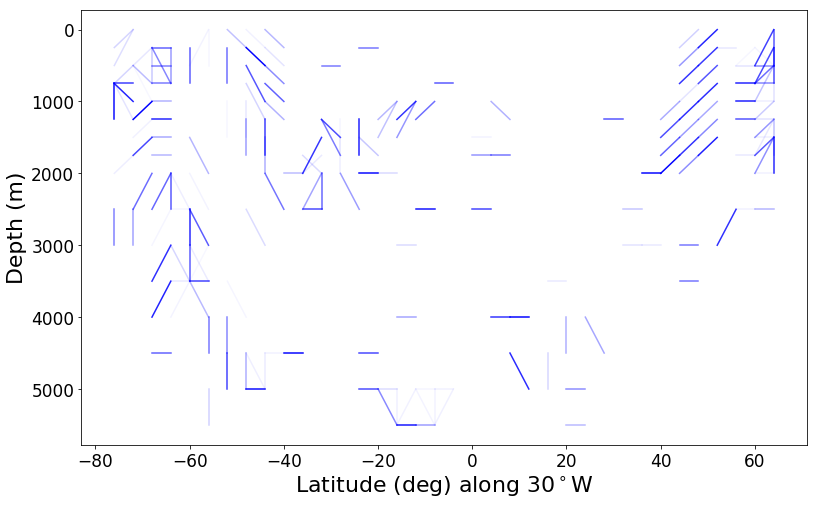

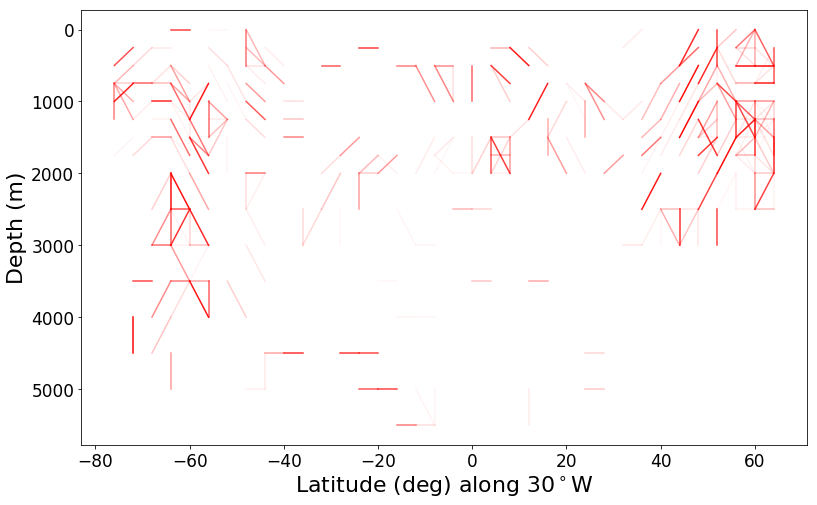

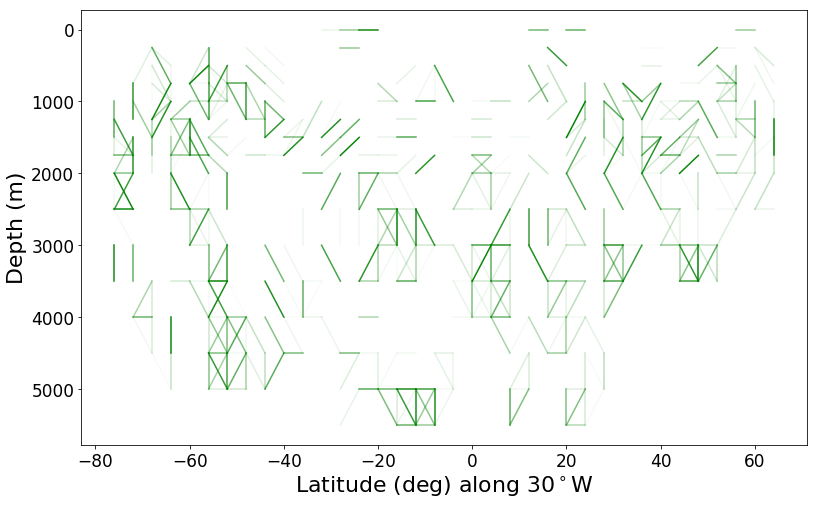

In [41]:
lineLon = -30
minLat, maxLat = -80, 80
# fig = plt.figure(figsize = (13, 8)) 
# ax = fig.add_subplot(111)
tracer_d = {'temperature':'blue', 'salinity': 'red', 'phosphate': 'green'}

for tracer in tracer_d.keys():
    dataset = dataFetcher()
    dataset.get_section('NS_section', lineLon, [minLat, maxLat], [tracer])
    
    d_traj = {}
    # standardize the depths of interest between locations
    for dpth in depths:
        Atl = water_column(dataset, 'traj', depth= dpth) 
        d_traj[dpth] = Atl

    # create sections that are 3 deg x 3 deg and however deep data is available
    minisections = []
    for (slat, nlat) in lat_bins:
        minisections.append(minisection(d_traj, nlat, slat)) #

    # calculate connectedness between section depths (vertical, horizontal, diagonal)
    Atl_paths = paths(500, minisections, .01, .05) # window for diagonal, sections list, p values
    
    fig = plt.figure(figsize = (13, 8)) 
    ax = fig.add_subplot(111)
    for key in Atl_paths.d_paths.keys():
        values = Atl_paths.d_paths[key]
        for value in values:
            ax.plot([key[0], value[0]],[key[1], value[1]], c = tracer_d[tracer] ,alpha = 1-(1-3*value[2]) )
    ax.set_ylabel('Depth (m)', fontsize=axis_sz)
    ax.set_xlabel('Latitude (deg) along {}$^\circ$W'.format(-lineLon), fontsize=axis_sz)

    # set tick parameters
    xtickNames = ax.get_xticklabels()
    ytickNames = ax.get_yticklabels()
    
    for names in [ytickNames, xtickNames]:
        plt.setp(names, rotation=0, fontsize=tick_sz-4)
#     ax.set_title(tracer)
    plt.gca().invert_yaxis()